In [27]:
import pandas as pd
import numpy as np
import json
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [2]:
# ----------------------------
# Load datasets
# ----------------------------
df = pd.read_csv("data/Depression_Severity_Levels_Dataset.csv")

In [3]:
df = df.dropna(subset=["text"])  # remove nulls

# Binary label conversion
df['binary_label'] = df['label'].apply(lambda x: 'NO' if x.strip().lower() == 'minimum' else 'YES')

# Label encoding
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['binary_label'])  # YES=1, NO=0

In [4]:
# Tokenization and padding
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100

In [5]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])

sequences = tokenizer.texts_to_sequences(df['text'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [6]:
# ----------------------------
# Apply SMOTE
# ----------------------------
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(padded_sequences, df['label_encoded'])

g:\Depression_Detection\venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [7]:
# ----------------------------
# Save resampled data
# ----------------------------
# Convert back to DataFrame
resampled_df = pd.DataFrame(X_resampled)
resampled_df['label'] = y_resampled
resampled_df['label'] = resampled_df['label'].map({0: 'NO', 1: 'YES'})

In [ ]:
# Save it
resampled_df.to_csv("data/smote_padded_dataset.csv", index=False)
print("✅ SMOTE-balanced padded dataset saved as smote_padded_dataset.csv")

✅ SMOTE-balanced padded dataset saved as smote_padded_dataset.csv


In [10]:
resampled_df.shape

(62620, 101)

In [12]:
# ----------------------------
# Load padded and SMOTE-balanced dataset
# ----------------------------
df = pd.read_csv("data/smote_padded_dataset.csv")

In [13]:
# Separate features and labels
X = df.drop(columns=['label']).values
y = df['label'].map({'NO': 0, 'YES': 1}).values

In [16]:
# One-hot encode labels
y_cat = to_categorical(y)

In [17]:
# ----------------------------
# Train/test split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42)

In [18]:
# ----------------------------
# LSTM model
# ----------------------------
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = X.shape[1]

model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=64, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(128),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
# ----------------------------
# Train model
# ----------------------------
model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=5, batch_size=64)

Epoch 1/5
783/783 [==============================] - 157s 196ms/step - loss: 0.4429 - accuracy: 0.8078 - val_loss: 0.3268 - val_accuracy: 0.8572
Epoch 2/5
783/783 [==============================] - 154s 196ms/step - loss: 0.3184 - accuracy: 0.8679 - val_loss: 0.2933 - val_accuracy: 0.8825
Epoch 3/5
783/783 [==============================] - 158s 201ms/step - loss: 0.2464 - accuracy: 0.8951 - val_loss: 0.2744 - val_accuracy: 0.8916
Epoch 4/5
783/783 [==============================] - 161s 206ms/step - loss: 0.2138 - accuracy: 0.9071 - val_loss: 0.2552 - val_accuracy: 0.8943
Epoch 5/5
783/783 [==============================] - 158s 202ms/step - loss: 0.1806 - accuracy: 0.9193 - val_loss: 0.2539 - val_accuracy: 0.8936


In [20]:
# ----------------------------
# Save model
# ----------------------------
model.save("lstm_model_smote.keras")
print("Trained LSTM model saved as lstm_model_smote.keras")

Trained LSTM model saved as lstm_model_smote.keras


In [21]:
# Predict with your trained LSTM model
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true_classes = np.argmax(y_test, axis=1)

392/392 [==============================] - 38s 93ms/step


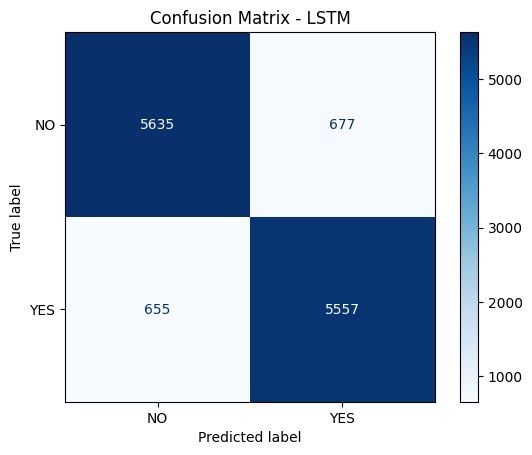

In [22]:
# Generate and display the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NO", "YES"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - LSTM")
plt.show()

In [23]:
# ----------------------------
# Evaluate
# ----------------------------
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n LSTM Test Accuracy: {acc:.4f}")


 LSTM Test Accuracy: 0.8936


In [32]:
from collections import Counter
print(Counter(np.argmax(y_test, axis=1)))

Counter({0: 6312, 1: 6212})


In [33]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), y_pred_classes))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      6312
           1       0.89      0.89      0.89      6212

    accuracy                           0.89     12524
   macro avg       0.89      0.89      0.89     12524
weighted avg       0.89      0.89      0.89     12524



In [24]:
new_text = ["I feel hopeless and tired all the time."]

In [25]:
# ----------------------------
# Preprocess using the same tokenizer and padding
# ----------------------------
sequence = tokenizer.texts_to_sequences(new_text)
padded = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [28]:
# ----------------------------
# Predict
# ----------------------------
pred = model.predict(padded)
predicted_class = tf.argmax(pred, axis=1).numpy()[0]

1/1 [==============================] - 0s 40ms/step


In [29]:
# Decode the label
label = le.inverse_transform([predicted_class])[0]

In [30]:
print(f"Input: {new_text[0]}")
print(f"Predicted Class: {label} (confidence = {pred[0][predicted_class]:.4f})")

Input: I feel hopeless and tired all the time.
Predicted Class: YES (confidence = 0.5904)


In [31]:
# Save tokenizer
token_json = tokenizer.to_json()
with open("tokenizer.json", "w") as f:
    f.write(token_json)